In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from helper_functions import helperFunctions as hf
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset,  Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from tabulate import tabulate

In [2]:
#import torch
#print(torch.cuda.is_available())

In [3]:
hf = hf("datafile.csv")

In [4]:
df = hf.import_datafile("datafile.csv")
df = df.fillna(0)

In [5]:
df.groupby(["S0", "k", "n", "m", "m6"])["E*"].nunique().value_counts()

E*
3    810
2    212
1    167
Name: count, dtype: int64

In [6]:
sorted_df = hf.processDfIntoMaterials(df)

## ML

In [7]:
input_df = sorted_df.drop(["S0", "k", "n", "m", "m6"], axis =1 )

In [8]:
params_df = sorted_df[["S0", "k", "n", "m", "m6"]]

In [9]:
input_df.shape, params_df.shape

((2430, 241), (2430, 5))

In [10]:
input_df = input_df.fillna(0)

## Regression

In [11]:
def process_data(input_df, params_df):
    input_data = []
    params_data = []
    for i in range(0, len(input_df), 3):
        input_data.append(input_df.iloc[i:i+3].values.flatten())
        params_data.append(params_df.iloc[i].values)  # Take only the first row of params
    return np.array(input_data), np.array(params_data)

X, y = process_data(input_df, params_df)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

print(X.shape, X_train.shape, y_train.shape)

# Step 4: Preprocessing
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Step 5: Create PyTorch Dataset and DataLoader
class CustomDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32).cuda()  # Move to GPU
        self.y = torch.tensor(y, dtype=torch.float32).cuda()  # Move to GPU

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dataset = CustomDataset(X_train_scaled, y_train)
test_dataset = CustomDataset(X_test_scaled, y_test)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64)

# Step 6: Define the Model
class RegressionModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RegressionModel, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(hidden_size, hidden_size)
        self.relu3 = nn.ReLU()
        self.fc4 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.fc2(x)
        x = self.relu2(x)
#         x = self.fc3(x)
#         x = self.relu3(x)
        x = self.fc4(x)
        
        return x

# Step 7: Define Loss Function and Optimizer
model = RegressionModel(input_size=X_train.shape[1], hidden_size=1000, output_size=y_train.shape[1]).cuda()  # Move to GPU
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)


(810, 723) (729, 723) (729, 5)


In [12]:

# Step 8: Training Loop
train_losses = []
num_epochs = 1200
for epoch in range(num_epochs):
    if epoch < 500:
        optimizer = optim.Adam(model.parameters(), lr=0.01)
    elif epoch < 800:
        optimizer = optim.Adam(model.parameters(), lr=0.0001)
    else:
        optimizer = optim.Adam(model.parameters(), lr=0.00001)
        
    model.train()
    running_loss = 0.0
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    epoch_loss = running_loss/len(train_loader)
    train_losses.append(epoch_loss)
    print(f'Epoch {epoch+1}, Loss: {epoch_loss}')

# Step 9: Evaluation
model.eval()
test_loss = 0.0
with torch.no_grad():
    for inputs, targets in test_loader:
        outputs = model(inputs)
        test_loss += criterion(outputs, targets).item()
print(f'Test Loss: {test_loss/len(test_loader)}')

Epoch 1, Loss: 5268.5745849609375
Epoch 2, Loss: 4835.3239339192705
Epoch 3, Loss: 4955.956675211589
Epoch 4, Loss: 2438.0760396321616
Epoch 5, Loss: 2204.6780598958335
Epoch 6, Loss: 2220.689656575521
Epoch 7, Loss: 1716.6790059407551
Epoch 8, Loss: 1463.869364420573
Epoch 9, Loss: 1563.2708028157551
Epoch 10, Loss: 2049.8409830729165
Epoch 11, Loss: 1408.9033915201824
Epoch 12, Loss: 1524.5393880208333
Epoch 13, Loss: 1597.1056162516277
Epoch 14, Loss: 1405.5368194580078
Epoch 15, Loss: 1269.8755696614583
Epoch 16, Loss: 1068.7094472249348
Epoch 17, Loss: 1081.6730397542317
Epoch 18, Loss: 1382.0945892333984
Epoch 19, Loss: 1298.9095865885417
Epoch 20, Loss: 1080.8816782633464
Epoch 21, Loss: 1544.4520975748699
Epoch 22, Loss: 1178.0157877604167
Epoch 23, Loss: 1007.116689046224
Epoch 24, Loss: 1274.6329447428386
Epoch 25, Loss: 1048.1548411051433
Epoch 26, Loss: 1016.7906087239584
Epoch 27, Loss: 1235.4007670084636
Epoch 28, Loss: 981.1350123087565
Epoch 29, Loss: 1366.7052205403645

Epoch 238, Loss: 863.3375549316406
Epoch 239, Loss: 2986.2087326049805
Epoch 240, Loss: 674.0153249104818
Epoch 241, Loss: 768.1664085388184
Epoch 242, Loss: 647.3436075846354
Epoch 243, Loss: 563.5808258056641
Epoch 244, Loss: 716.0098571777344
Epoch 245, Loss: 735.291249593099
Epoch 246, Loss: 571.3141949971517
Epoch 247, Loss: 1316.8386967976887
Epoch 248, Loss: 726.3389078776041
Epoch 249, Loss: 688.6879692077637
Epoch 250, Loss: 501.21532313028973
Epoch 251, Loss: 643.0376790364584
Epoch 252, Loss: 486.15853118896484
Epoch 253, Loss: 819.2826131184896
Epoch 254, Loss: 683.0849456787109
Epoch 255, Loss: 874.2702356974283
Epoch 256, Loss: 485.0180956522624
Epoch 257, Loss: 1063.670244852702
Epoch 258, Loss: 543.5160077412924
Epoch 259, Loss: 532.6566327412924
Epoch 260, Loss: 473.5528195699056
Epoch 261, Loss: 551.1146125793457
Epoch 262, Loss: 488.9794336954753
Epoch 263, Loss: 693.5494155883789
Epoch 264, Loss: 567.077273050944
Epoch 265, Loss: 857.8616053263346
Epoch 266, Loss: 7

Epoch 471, Loss: 342.69657135009766
Epoch 472, Loss: 348.30930010477704
Epoch 473, Loss: 367.992000579834
Epoch 474, Loss: 293.6067924499512
Epoch 475, Loss: 460.6498196919759
Epoch 476, Loss: 401.1756362915039
Epoch 477, Loss: 311.32814661661786
Epoch 478, Loss: 264.61541112263996
Epoch 479, Loss: 306.1690985361735
Epoch 480, Loss: 244.4842357635498
Epoch 481, Loss: 400.86356353759766
Epoch 482, Loss: 337.73664538065594
Epoch 483, Loss: 317.5448188781738
Epoch 484, Loss: 317.8769652048747
Epoch 485, Loss: 240.11980183919272
Epoch 486, Loss: 336.9039166768392
Epoch 487, Loss: 293.050973256429
Epoch 488, Loss: 280.0158093770345
Epoch 489, Loss: 272.6396344502767
Epoch 490, Loss: 307.95432980855304
Epoch 491, Loss: 422.1256510416667
Epoch 492, Loss: 247.6665471394857
Epoch 493, Loss: 425.5209903717041
Epoch 494, Loss: 342.5578142801921
Epoch 495, Loss: 351.0224672953288
Epoch 496, Loss: 463.7562948862712
Epoch 497, Loss: 331.5094509124756
Epoch 498, Loss: 259.7931874593099
Epoch 499, Los

Epoch 708, Loss: 41.544306914011635
Epoch 709, Loss: 42.48305161794027
Epoch 710, Loss: 41.911768754323326
Epoch 711, Loss: 41.7607037226359
Epoch 712, Loss: 41.16572539011637
Epoch 713, Loss: 44.961968421936035
Epoch 714, Loss: 41.8428209622701
Epoch 715, Loss: 42.59423939387003
Epoch 716, Loss: 42.20260492960612
Epoch 717, Loss: 41.45044771830241
Epoch 718, Loss: 42.022240002950035
Epoch 719, Loss: 40.943441232045494
Epoch 720, Loss: 41.60729440053304
Epoch 721, Loss: 41.60331265131632
Epoch 722, Loss: 40.571189403533936
Epoch 723, Loss: 40.42257706324259
Epoch 724, Loss: 44.262612660725914
Epoch 725, Loss: 40.778261025746666
Epoch 726, Loss: 40.97063318888346
Epoch 727, Loss: 40.61382341384888
Epoch 728, Loss: 40.604167461395264
Epoch 729, Loss: 41.14901860555013
Epoch 730, Loss: 40.64754136403402
Epoch 731, Loss: 40.569361209869385
Epoch 732, Loss: 40.54205131530762
Epoch 733, Loss: 40.41511249542236
Epoch 734, Loss: 42.731476624806724
Epoch 735, Loss: 40.46766455968221
Epoch 736, 

Epoch 945, Loss: 38.39764738082886
Epoch 946, Loss: 36.715742111206055
Epoch 947, Loss: 36.87671724955241
Epoch 948, Loss: 36.72623157501221
Epoch 949, Loss: 37.73301696777344
Epoch 950, Loss: 37.48806492487589
Epoch 951, Loss: 36.95921564102173
Epoch 952, Loss: 36.77943595250448
Epoch 953, Loss: 37.49341646830241
Epoch 954, Loss: 37.99968989690145
Epoch 955, Loss: 36.76904694239298
Epoch 956, Loss: 36.91802008946737
Epoch 957, Loss: 37.21987803777059
Epoch 958, Loss: 36.72383260726929
Epoch 959, Loss: 36.96088298161825
Epoch 960, Loss: 38.38538773854574
Epoch 961, Loss: 37.72728109359741
Epoch 962, Loss: 37.53367201487223
Epoch 963, Loss: 37.05297406514486
Epoch 964, Loss: 37.287773291269936
Epoch 965, Loss: 37.675204594930015
Epoch 966, Loss: 37.312085469563804
Epoch 967, Loss: 37.54331684112549
Epoch 968, Loss: 37.04301659266154
Epoch 969, Loss: 37.693814277648926
Epoch 970, Loss: 36.83243481318156
Epoch 971, Loss: 37.86304791768392
Epoch 972, Loss: 40.081559340159096
Epoch 973, Los

Epoch 1173, Loss: 36.97983614603678
Epoch 1174, Loss: 37.56273047129313
Epoch 1175, Loss: 36.20939429601034
Epoch 1176, Loss: 38.1305513381958
Epoch 1177, Loss: 36.33040459950765
Epoch 1178, Loss: 37.24557447433472
Epoch 1179, Loss: 36.29929860432943
Epoch 1180, Loss: 37.04630517959595
Epoch 1181, Loss: 36.40936803817749
Epoch 1182, Loss: 37.36634874343872
Epoch 1183, Loss: 37.515474796295166
Epoch 1184, Loss: 36.4723097483317
Epoch 1185, Loss: 35.96344804763794
Epoch 1186, Loss: 37.370467821756996
Epoch 1187, Loss: 36.136497020721436
Epoch 1188, Loss: 36.152268727620445
Epoch 1189, Loss: 36.906225045522056
Epoch 1190, Loss: 37.57954184214274
Epoch 1191, Loss: 36.34000571568807
Epoch 1192, Loss: 36.49114449818929
Epoch 1193, Loss: 36.28746827443441
Epoch 1194, Loss: 35.99240382512411
Epoch 1195, Loss: 36.93610445658366
Epoch 1196, Loss: 38.0862922668457
Epoch 1197, Loss: 36.23410304387411
Epoch 1198, Loss: 35.895775159200035
Epoch 1199, Loss: 35.95581452051798
Epoch 1200, Loss: 35.7582

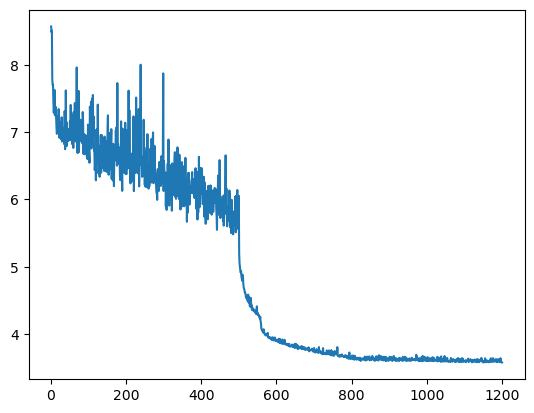

In [13]:
plt.plot(range(1, num_epochs+1), np.log(train_losses), label='Training Loss')

In [14]:
[X_test[0][(i+1)*240+i] for i in range(3)]

[0.01, 0.1, 0.5]

In [15]:
X_test.shape[1]/3

241.0

In [16]:
def testMLParams(index, p=True):
    inputs, targets = next(iter(test_loader))
    real_params = pd.DataFrame(y_test).iloc[index]
    # Move the input data to the GPU
    inputs_cuda = torch.tensor(X_test_scaled[index], dtype=torch.float32).cuda()

    # Pass the input data through the model (which is already on the GPU)
    outputs_cuda = model(inputs_cuda)

    # Detach from the computation graph, move to CPU, and convert to numpy array
    pred_params = outputs_cuda.detach().cpu().numpy()
    for i in range(3):
        epsilon_dot = pd.DataFrame(X_test).iloc[index][(i + 1) * 240 + i]
        eps_input = hf.DEFAULT_EPS_ARRAY
        evalParams(real_params, pred_params, epsilon_dot, eps_input, p)


def evalParams(real_params, pred_params, epsilon_dot, eps_input, p=True):
    sigma0, k, n, m, m6 = real_params
    eq_curve = hf.viscoPlasticLaw(sigma0, k, n, m, m6, epsilon_dot, eps_input)
    sigma0_opt, k_opt, n_opt, m_opt, m6_opt = pred_params
    pred_curve = hf.viscoPlasticLaw(sigma0_opt, k_opt, n_opt, m_opt, m6_opt, epsilon_dot, eps_input)

    if p:
        print("EPSILON DOT", epsilon_dot)
        hf.plotCurves(eq_curve, pred_curve, eps_input)

        # Define data as a list of tuples
        data = [
            ("k", k_opt, k),
            ("n", n_opt, n),
            ("m", m_opt, m),
            ("m6", m6_opt, m6),
            ("sigma0", sigma0_opt, sigma0)
        ]

        # Print as a table
        table = tabulate(data, headers=["Parameter", "Pred Value", "Real Value"], tablefmt="grid")
        print(table)
    return np.mean((pred_curve - eq_curve) ** 2)


EPSILON DOT 0.01


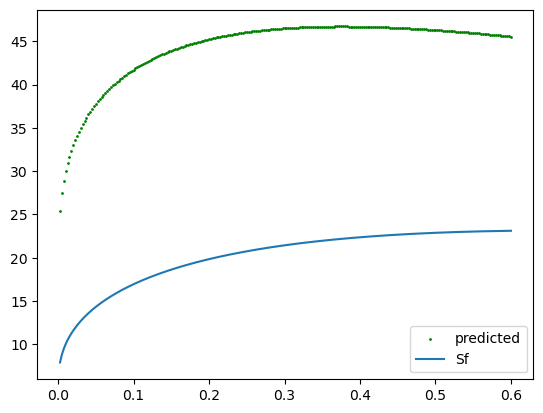

+-------------+--------------+--------------+
| Parameter   |   Pred Value |   Real Value |
+=============+==============+==============+
| k           |   81.5213    |         80   |
+-------------+--------------+--------------+
| n           |    0.305404  |          0.4 |
+-------------+--------------+--------------+
| m           |    0.0846624 |          0.2 |
+-------------+--------------+--------------+
| m6          |   -0.812615  |         -0.6 |
+-------------+--------------+--------------+
| sigma0      |   16.5575    |          5   |
+-------------+--------------+--------------+
EPSILON DOT 0.1


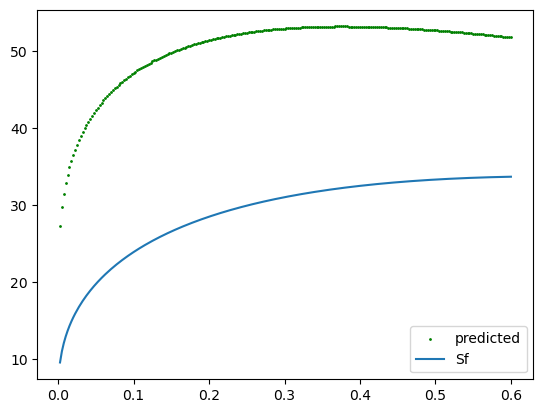

+-------------+--------------+--------------+
| Parameter   |   Pred Value |   Real Value |
+=============+==============+==============+
| k           |   81.5213    |         80   |
+-------------+--------------+--------------+
| n           |    0.305404  |          0.4 |
+-------------+--------------+--------------+
| m           |    0.0846624 |          0.2 |
+-------------+--------------+--------------+
| m6          |   -0.812615  |         -0.6 |
+-------------+--------------+--------------+
| sigma0      |   16.5575    |          5   |
+-------------+--------------+--------------+
EPSILON DOT 0.5


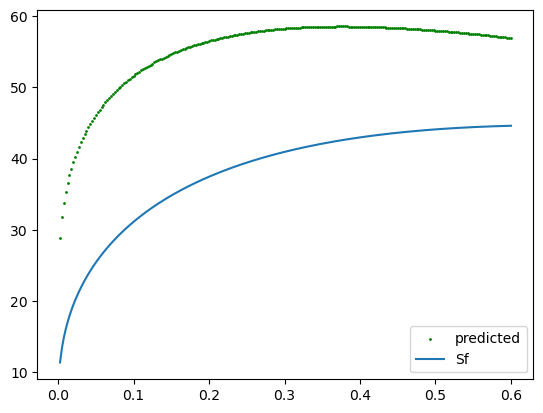

+-------------+--------------+--------------+
| Parameter   |   Pred Value |   Real Value |
+=============+==============+==============+
| k           |   81.5213    |         80   |
+-------------+--------------+--------------+
| n           |    0.305404  |          0.4 |
+-------------+--------------+--------------+
| m           |    0.0846624 |          0.2 |
+-------------+--------------+--------------+
| m6          |   -0.812615  |         -0.6 |
+-------------+--------------+--------------+
| sigma0      |   16.5575    |          5   |
+-------------+--------------+--------------+


In [17]:
testMLParams(10)

In [18]:
def getResultDataframe(test_loader, model, criterion, scaler):
    results = []
    with torch.no_grad():
        for inputs_set, targets_set in test_loader:
            for (inputs, targets) in zip(inputs_set, targets_set):
                outputs = model(inputs)
                unsqueezed_inputs = inputs.cpu().numpy().reshape(1, len(inputs.cpu().numpy()))
                epsilon_dot = scaler.inverse_transform(unsqueezed_inputs)[0][-1]
                sigma0, k, n, m, m6 = targets.cpu().numpy()
                sigma0_opt, k_opt, n_opt, m_opt, m6_opt = outputs.cpu().numpy()
                
                
                curveError = evalParams(targets.cpu().numpy(), outputs.cpu().numpy(), epsilon_dot, hf.DEFAULT_EPS_ARRAY, False)
                results.append({
                    'sigma0': sigma0_opt,
                    'k_opt': k_opt,
                    'n_opt': n_opt,
                    'm_opt': m_opt,
                    'm6_opt': m6_opt,
                    'error_opt': "na",
                    'sigma0': sigma0,
                    'k_real': k,
                    'n_real': n,
                    'm_real': m,
                    'm6_real': m6,
                    'param_error': np.log(criterion(outputs, targets).item()),
                    'curve_error': np.log(curveError)
            })
    return pd.DataFrame(results)

In [19]:
results = getResultDataframe(train_loader, model, criterion, scaler)

In [35]:
results.loc[(results["k_real"] == 50) & (results["n_real"] == 0.05) & (results["m_real"] == 0.2) & (results["sigma0"] == 5)]

,sigma0,k_opt,n_opt,m_opt,m6_opt,error_opt,k_real,n_real,m_real,m6_real,param_error,curve_error
15,5.0,54.286819,0.303070,0.085634,-0.817448,na,50.0,0.05,0.2,-1.2,3.365286,4.845081
290,5.0,59.207897,0.303094,0.083600,-0.792053,na,50.0,0.05,0.2,-0.3,3.809682,3.231298
535,5.0,56.660992,0.303005,0.084295,-0.800474,na,50.0,0.05,0.2,-0.6,3.583568,3.923498
717,5.0,48.360489,0.302563,0.085846,-0.818500,na,50.0,0.05,0.2,-2.0,3.247836,5.338090


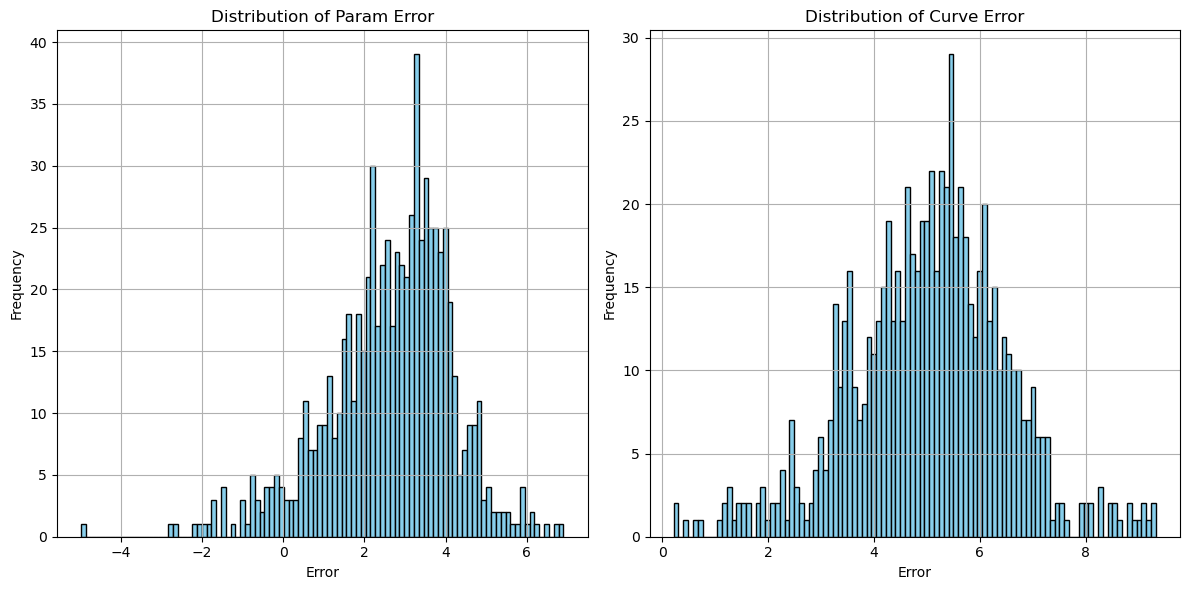

In [21]:
# Assuming results is your DataFrame containing both 'error' and 'error_opt' columns

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.hist(results['param_error'], bins=100, color='skyblue', edgecolor='black')
plt.title('Distribution of Param Error')
plt.xlabel('Error')
plt.ylabel('Frequency')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.hist(results['curve_error'], bins=100, color='skyblue', edgecolor='black')
plt.title('Distribution of Curve Error')
plt.xlabel('Error')
plt.ylabel('Frequency')
plt.grid(True)

plt.tight_layout()  # Adjusts subplot parameters to give specified padding
plt.show()


## VAE For Dimensionality Reduction -> No Equation

In [22]:
# Use VAE to do dimensionality reduction as preprocessing
# Then train regressor on new hidden params 

In [23]:
# Define the VAE architecture
class VAE(nn.Module):
    def __init__(self, input_size, hidden_size, latent_size):
        super(VAE, self).__init__()
        
        self.encoder = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
        )
        self.mu = nn.Linear(hidden_size, latent_size)
        self.logvar = nn.Linear(hidden_size, latent_size)
        
        self.decoder = nn.Sequential(
            nn.Linear(latent_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, input_size),
            nn.Sigmoid(),
        )

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        h = self.encoder(x)
        mu, logvar = self.mu(h), self.logvar(h)

        z = self.reparameterize(mu, logvar)
        # print(z)
#         # Inject strain rate into the input of the decoder
#         z = torch.cat([z, strain_rate.unsqueeze(-1)], dim=1)
        
        return self.decoder(z), mu, logvar

# Loss function
def loss_function(recon_x, x, mu, logvar):
    BCE = nn.functional.mse_loss(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD


In [24]:
# Hyperparameters
input_size = 240
hidden_size = 128
latent_size = 64
batch_size = 32
epochs = 100
learning_rate = 1e-3

# Instantiate the VAE and optimizer
vae = VAE(input_size, hidden_size, latent_size)
optimizer = optim.Adam(vae.parameters(), lr=learning_rate)

# Create a DataLoader from your pandas DataFrame (assuming df is the DataFrame)
tensor_data = torch.tensor(pivot_df.values, dtype=torch.float32)
dataset = TensorDataset(tensor_data)
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)


NameError: name 'pivot_df' is not defined

In [ ]:

# Training loop
for epoch in range(epochs):
    train_loss = 0
    for batch_data in data_loader:
        x = batch_data[0]
        
        # Generate random strain rates for each sample in the batch
        strain_rate = torch.rand(x.size(0), device=x.device)
        
        optimizer.zero_grad()
        recon_x, mu, logvar = vae(x)
        
        loss = loss_function(recon_x, x, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
    
    print(f'Epoch {epoch+1}/{epochs}, Loss: {train_loss / len(data_loader.dataset)}')

In [ ]:

# Once training is done, you can use the encoder part of the VAE to perform dimensionality reduction
# For example, to obtain the latent representation of your data:
encoded_data = []
with torch.no_grad():
    vae.eval()
    for x in data:
        mu, _ = vae.encode(x)
        encoded_data.append(mu.numpy())

encoded_data = np.array(encoded_data)
print("Encoded data shape:", encoded_data.shape)
